About Data - Gruppe 4
=========


In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
import skimage as ski
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from pathlib import Path

BASEDIR = Path("/global/public/chabud-ecml-pkdd2023/")
fn = BASEDIR / "train_eval.hdf5"

In [2]:
def to_xarray(dataset, pretty_band_names=True):
    """Convert a single example into an xarray for easy access"""
    
    if pretty_band_names:
        BANDS = ["coastal_aerosol", "blue", "green", "red",
                 "veg_red_1", "veg_red_2", "veg_red_3", "nir", 
                 "veg_red_4", "water_vapour", "swir_1", "swir_2"]
    else:
        BANDS = ["1", "2", "3", "4", "5", "6", "7", "8", "8a", "9", "11", "12"]
        
    post = dataset["post_fire"][...].astype("float32") / 10000.0
    
    # Da `pre_fire` manchmal fehlt ersetzen wir es durch 0 Werte was
    # eh der Platzhalter für einen fehlenden Messwert ist.
    try:
        pre = dataset["pre_fire"][...].astype("float32") / 10000.0
    except KeyError:
        pre = np.zeros_like(post, dtype="float32")
        
    # Da die Maske nur ein "Band" hat können wir die dritte Dimension einfach
    # weglassen. Das erreichen wir in dem wir mit `0` am Ende indizieren.
    mask = dataset["mask"][..., 0].astype("bool")
    
    return {"pre": xr.DataArray(pre, dims=["x", "y", "band"], coords={"x": range(512), "y": range(512), "band": BANDS}),
            "post": xr.DataArray(post, dims=["x", "y", "band"], coords={"x": range(512), "y": range(512), "band": BANDS}),
            "mask": xr.DataArray(mask, dims=["x", "y"], coords={"x": range(512), "y": range(512)}),
            "fold": dataset.attrs["fold"]}

In [3]:
def return_with_prefire(data):
            if np.sum(data["pre"].values) >= 0:
                return data
            else:
                return 0

In [4]:
def return_enough_burned(data):
    total_area=512*512
    if np.sum(data["mask"].values)/total_area >=0.01:
        return data 
    else:
        return 0

In [5]:
#Sammeln der IDs/Namen von den Datasets, welche genug verbrannte Fläche haben und wo ein pre-fore eixtiert
res = []

with h5py.File(fn, "r") as fd:
    for name in fd:
        ds = to_xarray(fd[name])
        if return_with_prefire(ds)!=0:
            ds = return_with_prefire(ds)
            if return_enough_burned(ds)!=0:
                ds = return_enough_burned(ds)
                res.append(fd[name])

About Data - verschiedene Indexes im Vergleich
=========

In [6]:
# https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/

In [7]:
def NBR(data):
    return (data.sel(band="nir").values-data.sel(band="swir_2").values)/(data.sel(band="nir").values+data.sel(band="swir_2").values)

In [8]:
#wird assoziiert mit vegetation
def NDVI(data):
    return (data.sel(band="nir").values-data.sel(band="red").values)/(data.sel(band="nir").values+data.sel(band="red").values)

In [9]:
#ähnlich wie NDVI, beachtet aber mehr die grüne vegetation
def GNDVI(data):
    return (data.sel(band="nir").values-data.sel(band="green").values)/(data.sel(band="nir").values+data.sel(band="red").values)

In [10]:
#quantifiziert die grüne in der Vegetation, korrigiert Konditionen in der Atmosphäre
def EVI(data):
    return (data.sel(band="nir").values-data.sel(band="red").values)/(data.sel(band="nir").values+6*data.sel(band="red").values-7.5*data.sel(band="blue").values+1)

In [11]:
#Advanced Vegetation Index (AVI) is a numerical indicator, similar to NDVI, that uses the red and near-infrared spectral bands. Like NDVI, AVI is used in vegetation studies to monitor crop and forest variations over time.
def AVI(data):
    return (data.sel(band="nir").values*(1-data.sel(band="red").values)*(data.sel(band="nir").values-data.sel(band="red").values))^(1/3)


In [12]:
#SAVI is used to correct Normalized Difference Vegetation Index (NDVI) for the influence of soil brightness in areas where vegetative cover is low.
def SAVI(data):
    return ((data.sel(band="nir").values-data.sel(band="red").values)/(data.sel(band="nir").values+data.sel(band="red").values+0.428))*1.428

In [13]:
#NDMI is used to determine vegetation water content. It is calculated as a ratio between the NIR and SWIR values in traditional fashion
def NDMI(data):
    return (data.sel(band="nir").values-data.sel(band="swir_1").values)/(data.sel(band="nir").values+data.sel(band="swir_1").values)

In [14]:
#Moisture Stress Index is used for canopy stress analysis, productivity prediction and biophysical modeling. Interpretation of the MSI is inverted relative to other water vegetation indices; thus, higher values of the index indicate greater plant water stress and in inference, less soil moisture content. The values of this index range from 0 to more than 3 with the common range for green vegetation being 0.2 to 2
def MSI(data):
    return data.sel(band="swir_1").values-data.sel(band="nir").values
    

In [15]:
#In remote sensing, the Green Chlorophyll Index is used to estimate the content of leaf chlorophyll in various species of plants.
def GCI(data):
    return data.sel(band="water_vapour").values-data.sel(band="green").values

In [16]:
#Bare Soil Index (BSI) is a numerical indicator that combines blue, red, near infrared and short wave infrared spectral bands to capture soil variations.
def BSI(data):
    return ((data.sel(band="swir_1").values+data.sel(band="red").values)-(data.sel(band="nir").values+data.sel(band="blue").values))/((data.sel(band="swir_1").values+data.sel(band="red").values)+(data.sel(band="nir").values+data.sel(band="blue").values))

In [17]:
#Normalize Difference Water Index (NDWI) is use for the water bodies analysis. The index uses Green and Near infra-red bands of remote sensing images. The NDWI can enhance water information efficiently in most cases
def NDWI(data):
    return (data.sel(band="green").values-data.sel(band="nir").values)/(data.sel(band="green").values+data.sel(band="nir").values)

In [18]:
#The Normalized Difference Snow Index (NDSI) is a numerical indicator that shows snow cover over land areas
def NDSI(data):
    return (data.sel(band="green").values-data.sel(band="swir_1").values)/(data.sel(band="green").values+data.sel(band="swir_1").values)

In [19]:
#Normalized Difference Glacier Index (NDGI) is used to help detect and monitor glaciers by using the green and red spectral bands. This equation is commonly used in glacier detection and glacier monitoring applications
def NDGI(data):
    return (data.sel(band="green").values-data.sel(band="red").values)/(data.sel(band="green").values+data.sel(band="red").values)

In [20]:
res = []

with h5py.File(fn, "r") as fd:
    for name in fd:
        ds = to_xarray(fd[name])
        mask = ds["mask"]
        post = ds["post"]
        
        #NBR
        burnt = np.sum(mask * NBR(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NBR(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NBRS", "delta": delta.item()})
        #NDVI
        burnt = np.sum(mask * NDVI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDVI", "delta": delta.item()})        
        #GNDVI
        #burnt = np.sum(mask * GNDVI(post), axis=(0, 1)) / np.sum(mask)
        #fresh = np.sum((1 - mask) * GNDVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        #delta = burnt - fresh
        #res.append({"name": name, "band": "GNDVI", "delta": delta.item()})
        #EVI
        #burnt = np.sum(mask * EVI(post), axis=(0, 1)) / np.sum(mask)
        #fresh = np.sum((1 - mask) * EVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        #delta = burnt - fresh
        #res.append({"name": name, "band": "EVI", "delta": delta.item()})
        #AVI
        #burnt = np.sum(mask * AVI(post), axis=(0, 1)) / np.sum(mask)
        #fresh = np.sum((1 - mask) * AVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        #delta = burnt - fresh
        #res.append({"name": name, "band": "AVI", "delta": delta})
        #SAVI
        burnt = np.sum(mask * SAVI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * SAVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "SAVI", "delta": delta.item()})
        #NDMI
        burnt = np.sum(mask * NDMI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDMI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDMI", "delta": delta.item()})
        #MSI
        burnt = np.sum(mask * MSI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * MSI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        delta = np.sum(delta)
        res.append({"name": name, "band": "MSI", "delta": delta.item()})
        #GCI
        burnt = np.sum(mask * GCI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * GCI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        delta = np.sum(delta)
        res.append({"name": name, "band": "GCI", "delta": delta.item()})
        #BSI
        burnt = np.sum(mask * BSI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * BSI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "BSI", "delta": delta.item()})
        #NDWI
        burnt = np.sum(mask * NDWI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDWI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDWI", "delta": delta.item()})
        #NDSI
        burnt = np.sum(mask * NDSI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDSI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDSI", "delta": delta.item()})
        #NDGI
        burnt = np.sum(mask * NDGI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDGI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDGI", "delta": delta.item()})
    

/tmp/ipykernel_1617424/195695788.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="nir").values-data.sel(band="red").values)/(data.sel(band="nir").values+data.sel(band="red").values)
/tmp/ipykernel_1617424/195695788.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="nir").values-data.sel(band="red").values)/(data.sel(band="nir").values+data.sel(band="red").values)
/tmp/ipykernel_1617424/1309260706.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="green").values-data.sel(band="nir").values)/(data.sel(band="green").values+data.sel(band="nir").values)
/tmp/ipykernel_1617424/1309260706.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="green").values-data.sel(band="nir").values)/(data.sel(band="green").values+data.sel(band="nir").values)
/tmp/ipykernel_1617424/195695788.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="nir").valu

In [21]:
df_1 = pd.DataFrame(res)
del res

In [22]:
#adding bands from mersman code
res = []

with h5py.File(fn, "r") as fd:
    for name in fd:
        ds = to_xarray(fd[name])
        mask = ds["mask"]
        post = ds["post"]
        
        burnt = np.sum(mask * post, axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * post, axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        
        for band, value in zip(post.indexes["band"], delta.values, ):            
            res.append({"name": name, "band": band, "delta": value})

df_2 = pd.DataFrame(res)
frames = [df_1, df_2]
df = pd.concat(frames)

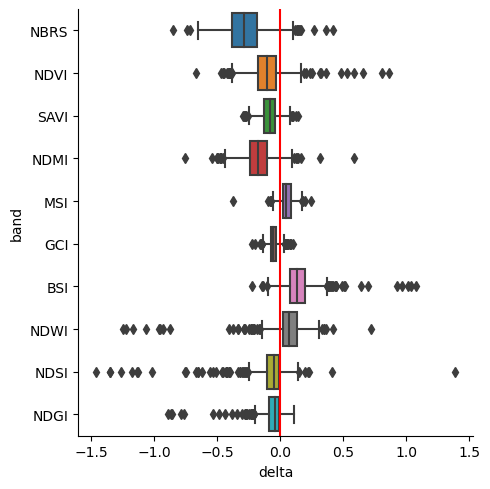

In [31]:
p = sns.catplot(df_1, x="delta", y="band", kind="box")
p.ax.axvline(0, color="red")

ValueError: cannot reindex on an axis with duplicate labels

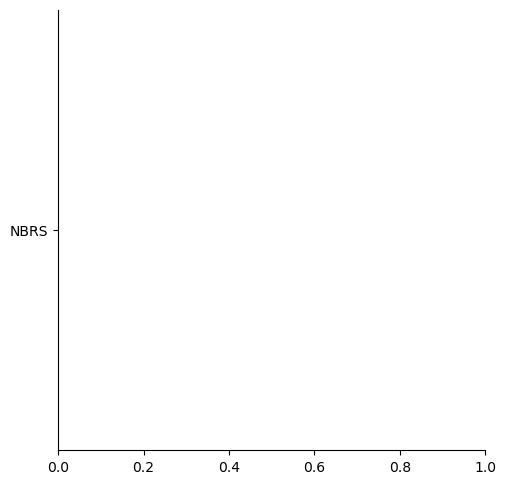

In [24]:
p = sns.catplot(df, x="delta", y="band", kind="strip")
p.ax.axvline(0, color="red")

In [ ]:
sns.displot(df, x="delta", hue="band", kind="ecdf", height=5, aspect=3)

In [27]:
res = []

with h5py.File(fn, "r") as fd:
    for name in fd:
        ds = to_xarray(fd[name])
        mask = ds["mask"]
        post = ds["post"]
        
        #this time skipping too big burned areas
        mask_value= ds["mask"].values
        percentage = np.sum(mask) / (512*512)
        if(percentage>=0.2):
            continue
        
        #NBR
        burnt = np.sum(mask * NBR(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NBR(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NBRS", "delta": delta.item()})
        #NDVI
        burnt = np.sum(mask * NDVI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDVI", "delta": delta.item()})        
        #GNDVI
        #burnt = np.sum(mask * GNDVI(post), axis=(0, 1)) / np.sum(mask)
        #fresh = np.sum((1 - mask) * GNDVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        #delta = burnt - fresh
        #res.append({"name": name, "band": "GNDVI", "delta": delta.item()})
        #EVI
        #burnt = np.sum(mask * EVI(post), axis=(0, 1)) / np.sum(mask)
        #fresh = np.sum((1 - mask) * EVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        #delta = burnt - fresh
        #res.append({"name": name, "band": "EVI", "delta": delta.item()})
        #AVI
        #burnt = np.sum(mask * AVI(post), axis=(0, 1)) / np.sum(mask)
        #fresh = np.sum((1 - mask) * AVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        #delta = burnt - fresh
        #res.append({"name": name, "band": "AVI", "delta": delta})
        #SAVI
        burnt = np.sum(mask * SAVI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * SAVI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "SAVI", "delta": delta.item()})
        #NDMI
        burnt = np.sum(mask * NDMI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDMI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDMI", "delta": delta.item()})
        #MSI
        burnt = np.sum(mask * MSI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * MSI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        delta = np.sum(delta)
        res.append({"name": name, "band": "MSI", "delta": delta.item()})
        #GCI
        burnt = np.sum(mask * GCI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * GCI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        delta = np.sum(delta)
        res.append({"name": name, "band": "GCI", "delta": delta.item()})
        #BSI
        burnt = np.sum(mask * BSI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * BSI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "BSI", "delta": delta.item()})
        #NDWI
        burnt = np.sum(mask * NDWI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDWI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDWI", "delta": delta.item()})
        #NDSI
        burnt = np.sum(mask * NDSI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDSI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDSI", "delta": delta.item()})
        #NDGI
        burnt = np.sum(mask * NDGI(post), axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * NDGI(post), axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        res.append({"name": name, "band": "NDGI", "delta": delta.item()})
df_small = pd.DataFrame(res)
del res

/tmp/ipykernel_1617424/195695788.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="nir").values-data.sel(band="red").values)/(data.sel(band="nir").values+data.sel(band="red").values)
/tmp/ipykernel_1617424/195695788.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="nir").values-data.sel(band="red").values)/(data.sel(band="nir").values+data.sel(band="red").values)
/tmp/ipykernel_1617424/1309260706.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="green").values-data.sel(band="nir").values)/(data.sel(band="green").values+data.sel(band="nir").values)
/tmp/ipykernel_1617424/1309260706.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="green").values-data.sel(band="nir").values)/(data.sel(band="green").values+data.sel(band="nir").values)
/tmp/ipykernel_1617424/195695788.py:3: RuntimeWarning: invalid value encountered in divide
  return (data.sel(band="nir").valu

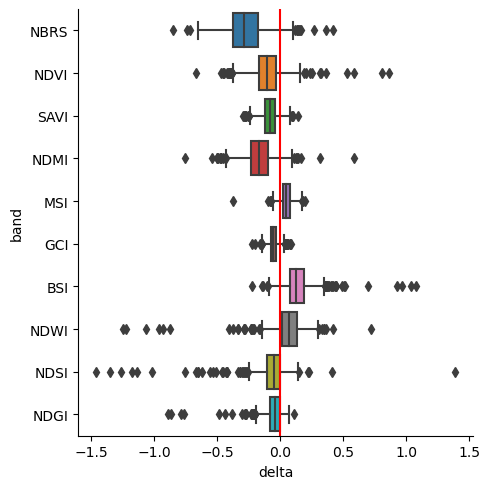

In [28]:
p = sns.catplot(df_small, x="delta", y="band", kind="box")
p.ax.axvline(0, color="red")

In [32]:
#mersman code but with skipping the too large areas
res = []

with h5py.File(fn, "r") as fd:
    for name in fd:
        ds = to_xarray(fd[name])
        mask = ds["mask"]
        post = ds["post"]
        
        burnt = np.sum(mask * post, axis=(0, 1)) / np.sum(mask)
        fresh = np.sum((1 - mask) * post, axis=(0, 1)) / np.sum(1 - mask)        
        delta = burnt - fresh
        
        for band, value in zip(post.indexes["band"], delta.values, ):            
            res.append({"name": name, "band": band, "delta": value})
df_small_band = pd.DataFrame(res)
del res

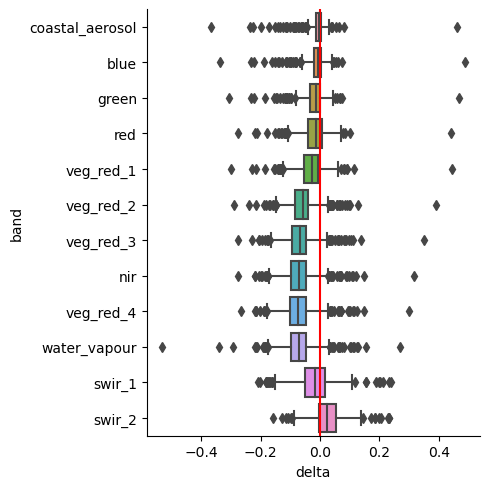

In [34]:
p = sns.catplot(df_small_band, x="delta", y="band", kind="box")
p.ax.axvline(0, color="red")

In [37]:
#mersman code but we just build the sum over the post bands
res = []

with h5py.File(fn, "r") as fd:
    for name in fd:
        ds = to_xarray(fd[name])
        #mask = ds["mask"]
        post = ds["post"]
        
        value = np.sum(post, axis=(0, 1))
        
        for band, value in zip(post.indexes["band"], value.values, ):            
            res.append({"name": name, "band": band, "value": value})
df_value_band = pd.DataFrame(res)
del res

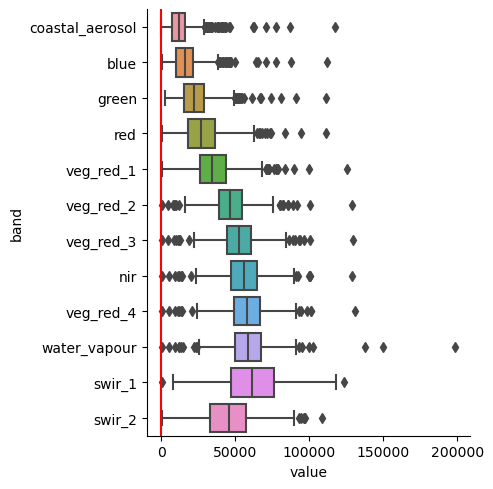

In [38]:
p = sns.catplot(df_value_band, x="value", y="band", kind="box")
p.ax.axvline(0, color="red")